# Group 4


## Problem Statement
Given this huge dataset of many various indicators, we would like to use machine learning, to be used on these indicators, that any regular adult can obtain by going through a health screening - to evaluate the risk any given individual has for heart disease.

### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1. [Data cleaning](#1)
    - [test](#1.1)
2. [Exploratory Data Analysis](#2)
    - [Visualisation](#2.1)
    - [Selecting best features](#2.2)
3. [Data Preparation](#3)
4. [Modeling](#4)
5. [Fine tuning](#5)

### Import the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import imblearn
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import Counter
from sklearn.datasets import make_classification
from pandas.api.types import is_string_dtype
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from scipy.stats import chi2 as chi_2
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

sb.set()

In [2]:
df = pd.read_csv('data/heart_2022_no_nans.csv')
# Preliminary check of the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  object 
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

From the above, we can see that there is a lot of categorical data. A few numerical data, like Height and Weight

***

<h1 align="center"><font color='Blue'>Data Cleaning</font></h1>

- We would like to first check if the data is clean. We can first check if there exists any rows that has nulls in them.

In [3]:
print(df.isnull().values.any())

False


<div class="alert alert-block alert-warning">  
<b>Observation:</b> This tells us that there are no null values in any of the rows in the dataset. This is good. Next, we want to check if there are any odd values in the dataset. We can do this by looking and eyeballing.
</div>

In [4]:
for column in df:
    if is_string_dtype(df[column]):
        print(column, df[column].unique())

State ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']
Sex ['Female' 'Male']
GeneralHealth ['Very good' 'Fair' 'Good' 'Excellent' 'Poor']
LastCheckupTime ['Within past year (anytime less than 12 months ago)'
 '5 or more years ago'
 'Within past 2 years (1 year but less than 2 years ago)'
 'Within past 5 years (2 years but less than 5 years ago)']
PhysicalActivities ['Yes' 'No']
RemovedTeeth ['None of t



<div class="alert alert-block alert-info">
<b>Plan:</b> We want to check for categorical data, as we will not be able to look for any "odd" values for numerical values until we do some form of analysis. Most of the columns look fine, but there are some weird ones

- HadDiabetes (Yes, but only during pregnancy (female))
- HadDiabetes (No, pre-diabetes or borderline diabetes)
- ECigaretteUsage (Not at all (right now))
- CovidPos (Tested positive using home test without a health professional)

We want to check if these values are significant. If they are not a significant portion of the dataset, looking at these features specifically would not give us any new insights.
</div>

In [5]:
print("Had Diabetes : Yes, but only during pregnancy (female) : ", len(df.loc[df['HadDiabetes'] == 'Yes, but only during pregnancy (female)']) / len(df))
print("Had Diabetes : No, pre-diabetes or borderline diabetes : ", len(df.loc[df['HadDiabetes'] == 'No, pre-diabetes or borderline diabetes']) / len(df))
print("ECigaretteUsage : Not at all (right now) : ", len(df.loc[df['ECigaretteUsage'] == 'Not at all (right now)']) / len(df))
print("CovidPos : Tested positive using home test without a health professional: ", len(df.loc[df['CovidPos'] == 'Tested positive using home test without a health professional']) / len(df))

Had Diabetes : Yes, but only during pregnancy (female) :  0.008060254773963304
Had Diabetes : No, pre-diabetes or borderline diabetes :  0.021916739153409043
ECigaretteUsage : Not at all (right now) :  0.17592329141296306
CovidPos : Tested positive using home test without a health professional:  0.034110770581492714


<div class="alert alert-block alert-warning">  
<b>Observation:</b> We can see that both options for <b>diabetes</b> is definitely not significant. <b>CovidPos</b> is also not significant as well. The option for <b>ECigarette</b> Usage is very significant, almost 1/5 of the dataset. We will keep that one in.
</div>

In [6]:
df['HadDiabetes'] = df['HadDiabetes'].replace('Yes, but only during pregnancy (female)', 'Yes')
df['HadDiabetes'] = df['HadDiabetes'].replace('No, pre-diabetes or borderline diabetes', 'No')
df['CovidPos'] = df['CovidPos'].replace('Tested positive using home test without a health professional', 'Yes')

Check that the replacements are correct.

In [7]:
print(df['HadDiabetes'].unique())
print(df['CovidPos'].unique())

['No' 'Yes']
['No' 'Yes']


In [8]:
df.head(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No




<div class="alert alert-block alert-info">  
<b>Plan:</b> Since the response column is the 'HadHeartAttack' column, we want to check if there is sufficient in the dataset.
</div>

In [9]:
print(df['HadHeartAttack'].value_counts())

HadHeartAttack
No     232587
Yes     13435
Name: count, dtype: int64


<div class="alert alert-block alert-warning">  
<b>Observation:</b> 
We notice that there is a significant class imbalance for <b>HadHeartAttack</b> here. For every ~24 rows, there will be one Yes. If we used the dataset as it is, then it will be significantly skewed towards 'No'. There will be poor performance on the minority class ('Yes') in this case. 

To fix this, we would downsample the amount of 'No's to the amount of 'Yes's, so that there is an equal amount. We would prefer to not do the alternative, to upsample the 'Yes', should be done with caution as is the nature of the dataset here (medical).

We also observe that there is sufficient rows of 'Yes's that we can use, even after we downsample (13k rows each is sufficient). We will have ~26k rows to work with and we bleieve that will be enough for this.
</div>

<h1 align="center"><font color='Blue'>Data exploration</font></h1>

Given so many variables, the immediate task is to find out which variables are the most meaningful and contribute to the final response (HadHeartAttack). We want to sieve out what's useful and what's not.

In [10]:
numeric = df.select_dtypes(include = ['int', 'float'])
categorical = df.select_dtypes(include = ['object'])

numeric.set_index(df.index)
numeric['HadHeartAttack'] = df['HadHeartAttack']
numeric.head()

#print("Number of numeric columns: ", len(numeric.columns))
#print("Number of categorical columns: ", len(categorical.columns))

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,HadHeartAttack
0,4.0,0.0,9.0,1.60,71.67,27.99,No
1,0.0,0.0,6.0,1.78,95.25,30.13,No
2,0.0,0.0,8.0,1.85,108.86,31.66,No
3,5.0,0.0,9.0,1.70,90.72,31.32,No
4,3.0,15.0,5.0,1.55,79.38,33.07,No


<h3 align="center"><font color='Green'>Numerical Data Analysis</font></h3>

 We first begin with numerical data analysis


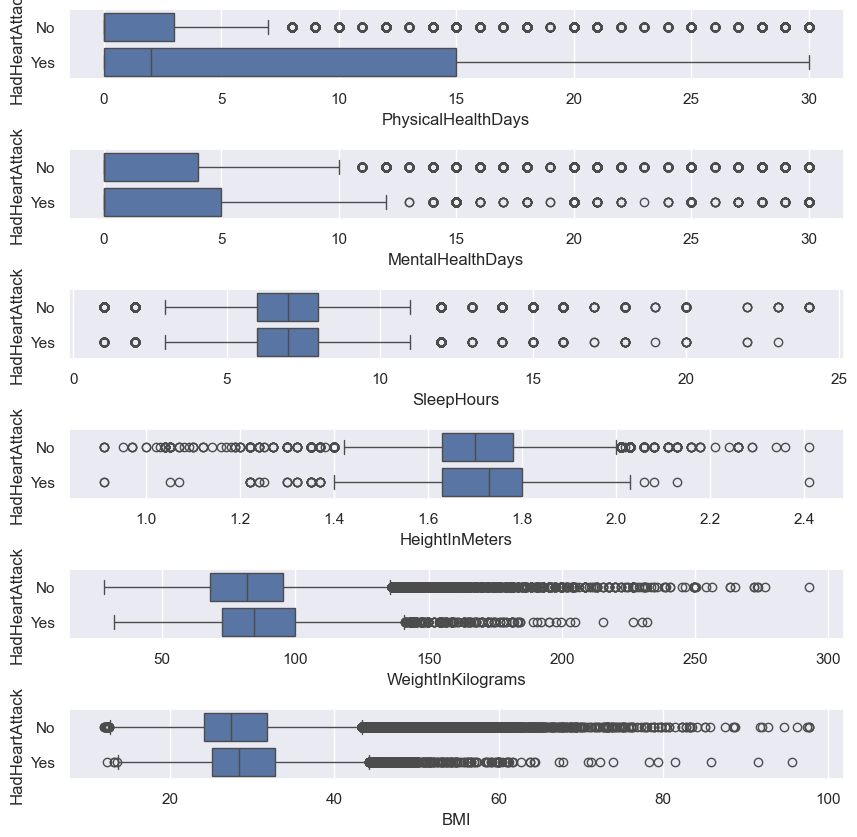

In [11]:
# Draw the distributions of all variables
f, axes = plt.subplots(6, 1, figsize=(10, 10), gridspec_kw={'hspace': 1})
f.subplots_adjust(hspace=0.3, wspace=0.3)

numerical_columns = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI' ]
for i, column in enumerate(numerical_columns):
    sb.boxplot(data = numeric, y='HadHeartAttack', x=column, orient = "h", ax = axes[i], showfliers = True)

<div class="alert alert-block alert-warning">
<b>Observation:</b> From the distribution of numeric data in this dataset, there is no noticeable partiiton to help classification with the exeception of <b>PhysicalHealthDays</b>. We can consider dropping <b>BMI, WeightInKilograms, HeightInMeters, MentalHealthDays</b>
</div>

<h3 align="center"><font color='green'>Categorical Data Analysis</font></h3>

We want to check see which categorical variables are best at predicting if a person has some form of heart disease.

In [12]:
# We don't want to include the HadHeartAttack column here as we want to compare against it.
categorical_columns = [col for col in df if is_string_dtype(df[col]) 
                       and col != 'HadHeartAttack'
                       and col != 'State'
                       and col != 'AgeCategory'
                       and col != 'RaceEthnicityCategory']
print(len(categorical_columns), categorical_columns)

30 ['Sex', 'GeneralHealth', 'LastCheckupTime', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']


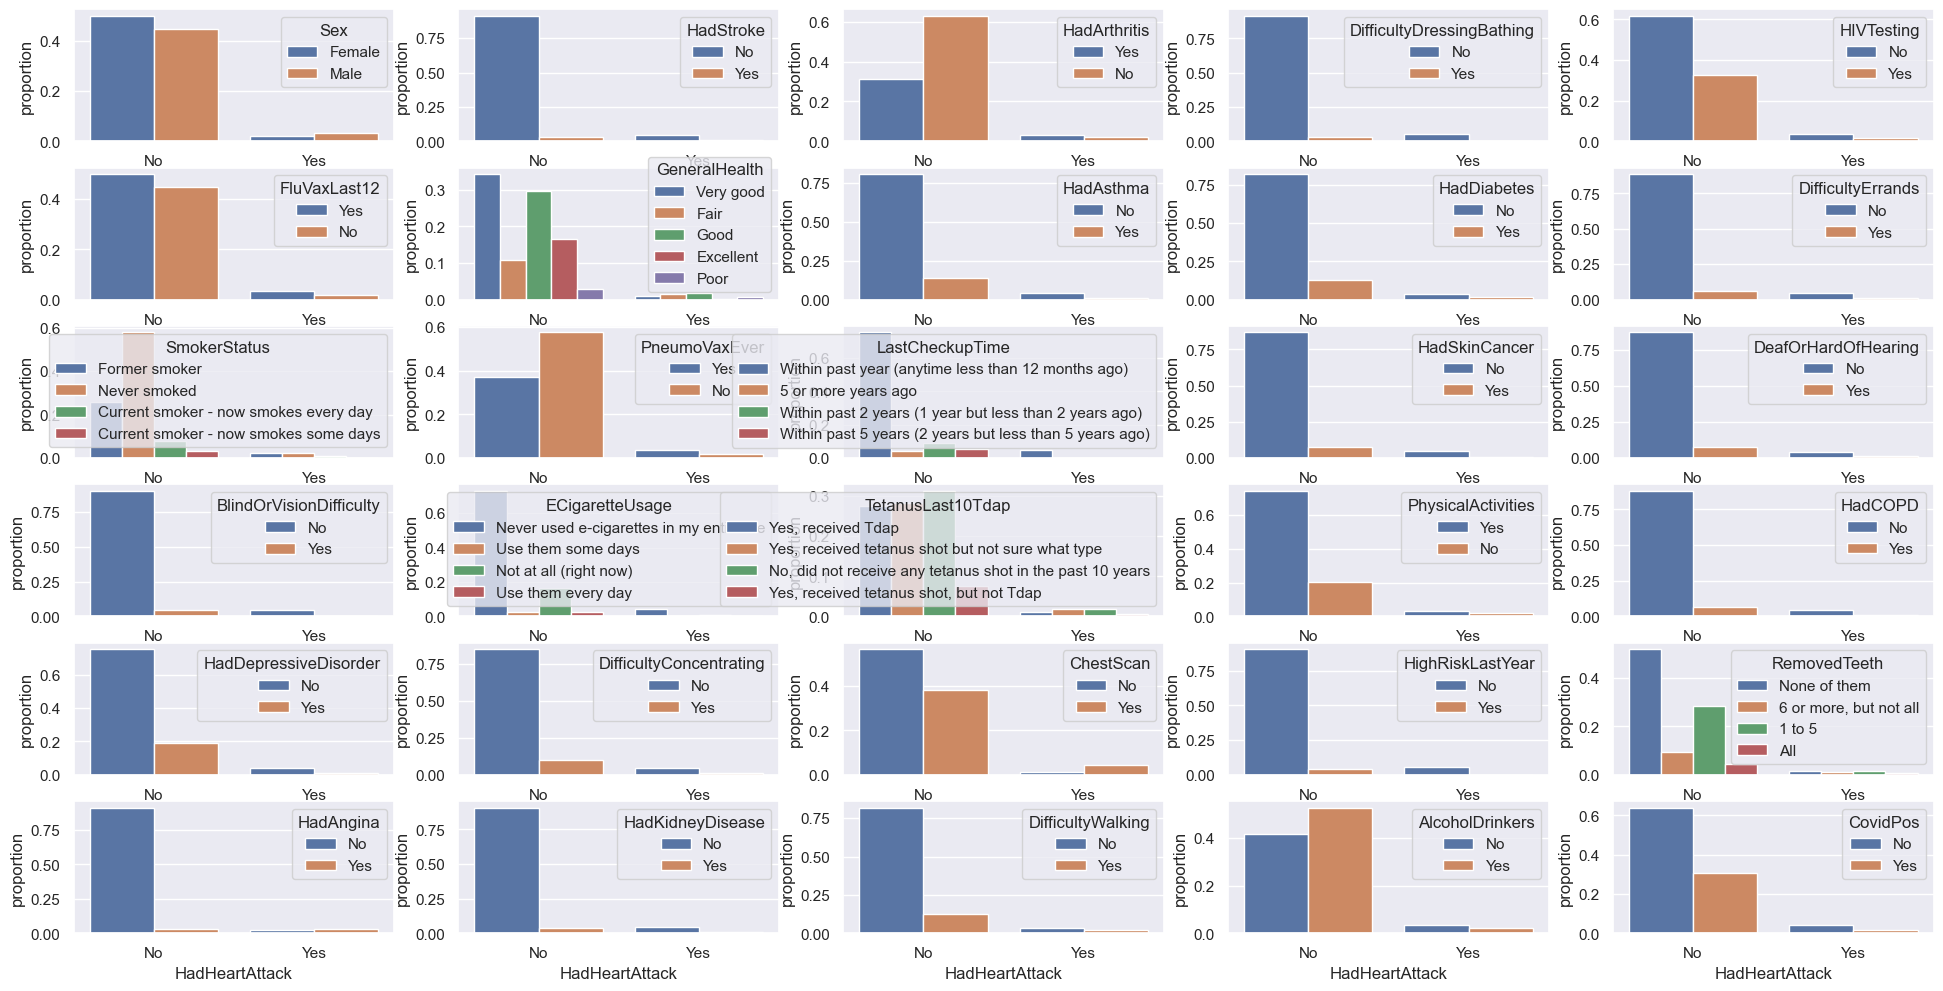

In [13]:
# 30 columns, so lets build 6x5 grid
f, axes = plt.subplots(6, 5, figsize=(24, 12))
for i, col in enumerate(categorical_columns):
    r = int(i % 6)
    c = int(i % 5)
    sb.countplot(pd.concat([df[col], df['HadHeartAttack']], axis=1),
                 x='HadHeartAttack', hue=col, stat='proportion',
                 legend='auto', ax=axes[r][c])

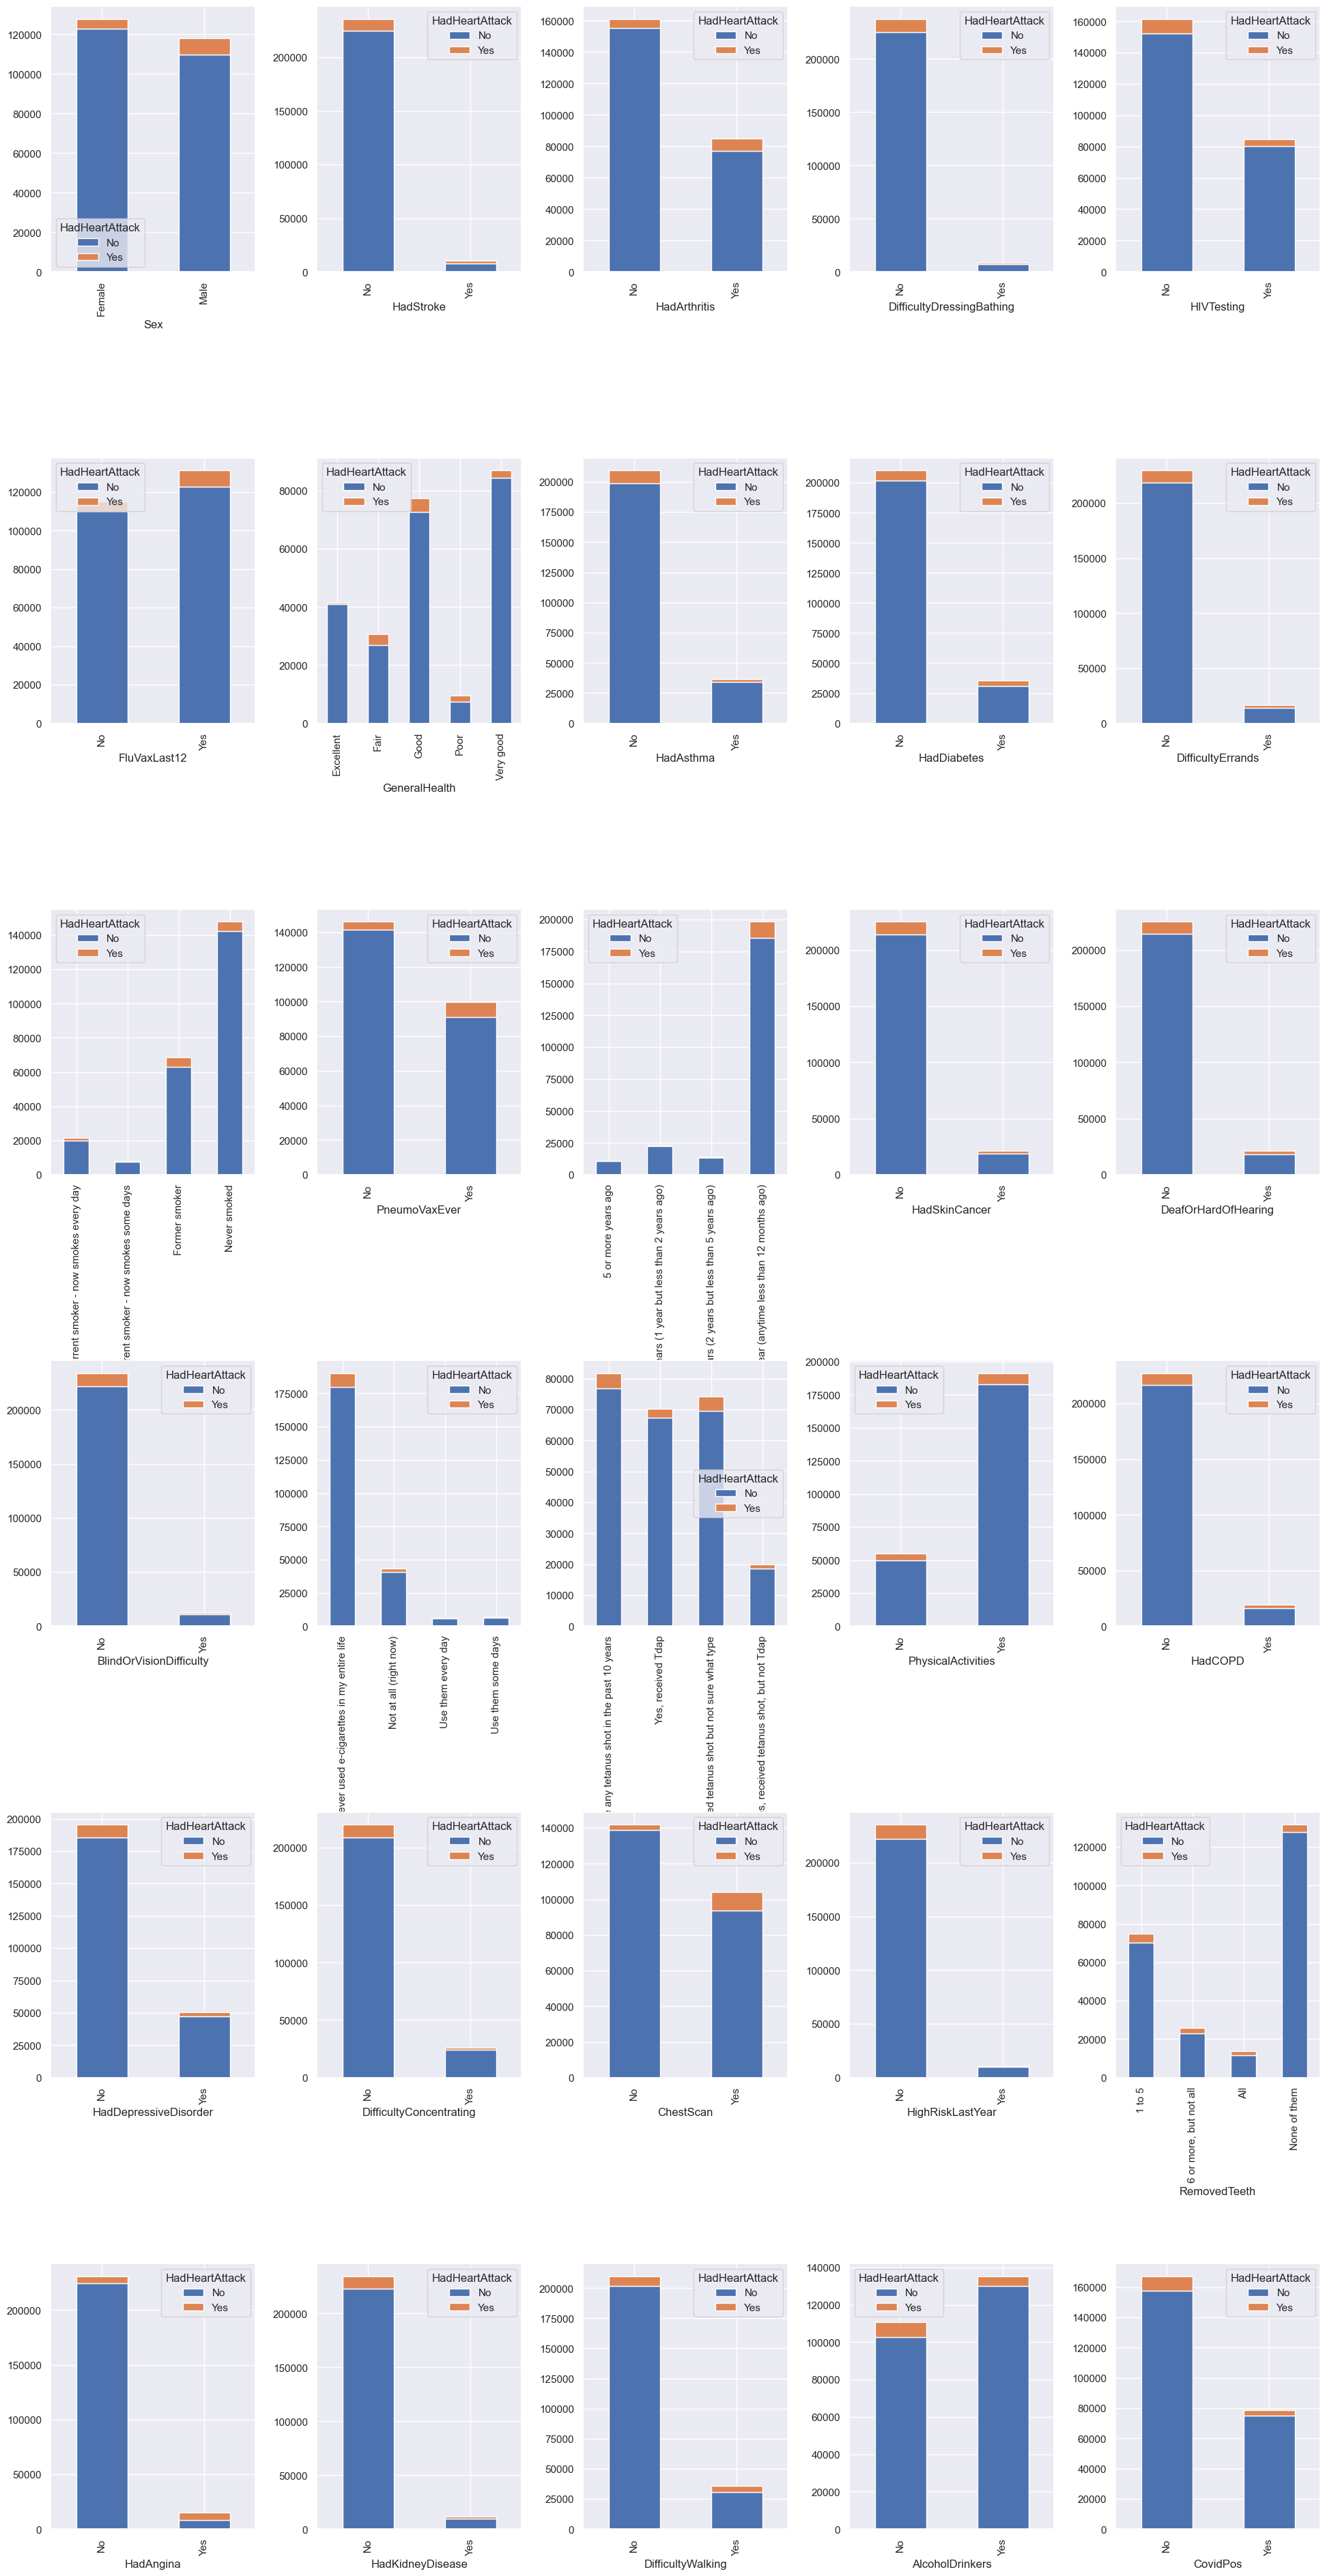

In [14]:
f, axes = plt.subplots(6, 5, figsize=(24, 48))
f.subplots_adjust(hspace=0.7, wspace=0.3)

for i, col in enumerate(categorical_columns):
    r = int(i % 6)
    c = int(i % 5)
    result= df.groupby(col)['HadHeartAttack'].value_counts().unstack()
    result.plot(kind='bar', stacked=True, ax=axes[r][c])

<div class="alert alert-block alert-warning">
    <b>Observation:</b> Based on obeservation alone, we can see some correlation between <b>HadStroke, DifficultyDressingBathing, HadAngina.</b> We will keep these variables in mind. // TODO- Explain how they are correlated. 
</div>

## Prepare the data

We have a few goals in this section. We want to prepare the dataset such that it is best suited for the computer to read (i.e. numbers, not strings).

1. For columns which are boolean (True/False), we want to encode them as 1/0
2. For categorical columns which have a **relationship**  between the categorical outcomes, that naturally encode as a hierarchy, $a < b < c$, we want to use ordinal encoding for them
3. For categorical columns which **do not** have any relationships between each other, we want to one-hot encode them.

In [15]:
# Label Encode
def encode_df(df):
    # df_encode = df.copy()
    for column in df.columns:
        # If there are only two columns, we can label encode
        if (len(df[column].value_counts()) == 2):
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    
    # Ordinal encoding
    # Where the values in each of these categories have relavance to each other
    if 'GeneralHealth' in df:
        df['GeneralHealth'] = df['GeneralHealth'].replace({'Poor': 0,'Fair': 1,'Good': 2,'Very good': 3,'Excellent': 4})
    if 'SmokerStatus' in df:
        df['SmokerStatus'] = df['SmokerStatus'].replace({'Never smoked': 0,'Former smoker': 1,'Current smoker - now smokes some days': 2,'Current smoker - now smokes every day': 3})
    if 'AgeCategory' in df:
        df['AgeCategory'] = df['AgeCategory'].replace({'Age 18 to 24': 0,'Age 25 to 29': 1, 'Age 30 to 34': 2,'Age 35 to 39': 3,'Age 40 to 44': 4,'Age 45 to 49': 5,'Age 50 to 54': 6,'Age 55 to 59': 7,'Age 60 to 64': 8,'Age 65 to 69': 9,'Age 70 to 74': 10,'Age 75 to 79': 11,'Age 80 or older': 12})
    if 'ECigaretteUsage' in df:
        df['ECigaretteUsage'] = df['ECigaretteUsage'].replace({'Never used e-cigarettes in my entire life': 0,'Not at all (right now)': 1,'Use them some days': 2,'Use them every day': 3})
    if 'TetanusLast10Tdap' in df:
        df['TetanusLast10Tdap'] = df['TetanusLast10Tdap'].replace({'Yes, received Tdap': 0, 'Yes, received tetanus shot but not sure what type': 1, 'No, did not receive any tetanus shot in the past 10 years': 2, 'Yes, received tetanus shot, but not Tdap': 3})

    # One hot encode the rest of the columns
    df = pd.get_dummies(df)

    return df

In [16]:
df_encoded = encode_df(df.copy())

## Feature selection

Given that this dataset has a lot of columns, we want to do some feature selection. We have visualized from above, while some categories are promising, it is still rather difficult to eyeball. Here, we want to feature select the top $n$ columns, (TODO - justify why $n$), and we can cross-validate to check if those columns are the important features.

TODO - justify which classifier we use `chi2`, `mutual_info_classif`, `f_classif`

# Chi Square Test

**Reasons for use:**

- wanted to verify our observations from EDA to find important features
- able find relationships between categorical features and response
- robust to outliers (extreme proportions)
- non parametric (no assumption to distribution of data)

In [17]:
x = df_encoded.drop(['HadHeartAttack'], axis=1)
y = df_encoded['HadHeartAttack']

n_features = 5
selector = SelectKBest(chi2, k=n_features)
x_new = selector.fit_transform(x, y)

# Print out the top columns
mask = selector.get_support()
important_features = []
# Loop over the same columns that we train on
for b, val in zip(mask, x.columns):
    if b:
        important_features.append(val)

print(important_features)

['PhysicalHealthDays', 'HadAngina', 'HadStroke', 'DifficultyWalking', 'AgeCategory']


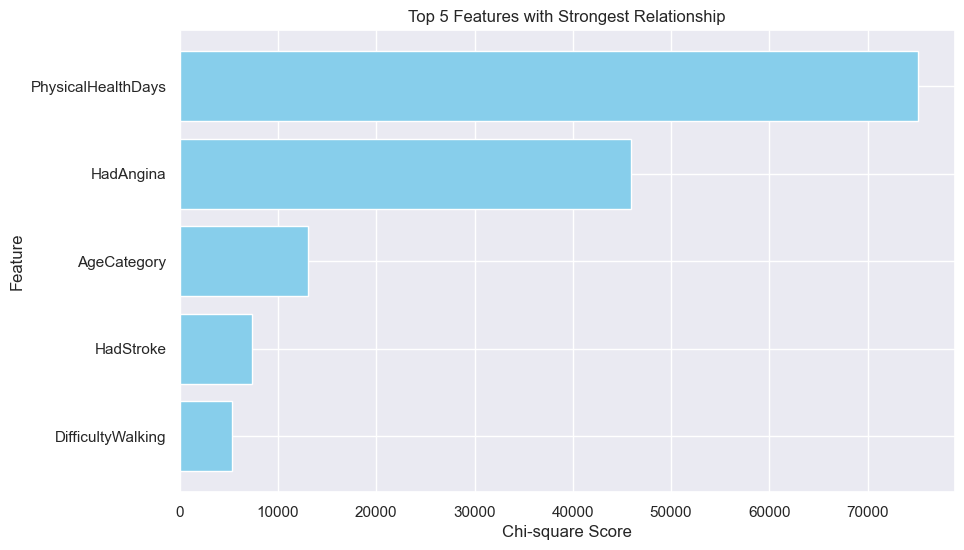

In [18]:
chi2_scores = selector.scores_
feature_names = x.columns
sorted_indices = np.argsort(chi2_scores)[::-1]  # Reverse order to get highest scores first
top_n_indices = sorted_indices[:n_features]
top_n_scores = chi2_scores[top_n_indices]
top_n_features = [feature_names[i] for i in top_n_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(np.arange(n_features), top_n_scores, color='skyblue')
plt.yticks(np.arange(n_features), top_n_features)
plt.title('Top {} Features with Strongest Relationship'.format(n_features))
plt.xlabel('Chi-square Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest score at the top
plt.show()

Given these important features that we have singled out, let's plot their graphs again to make sure that these are actually important features. With fewer of these columns, we should be able to see it's effect on the graph.

TODO - Pick one of the visualizations / find another one that shows this better

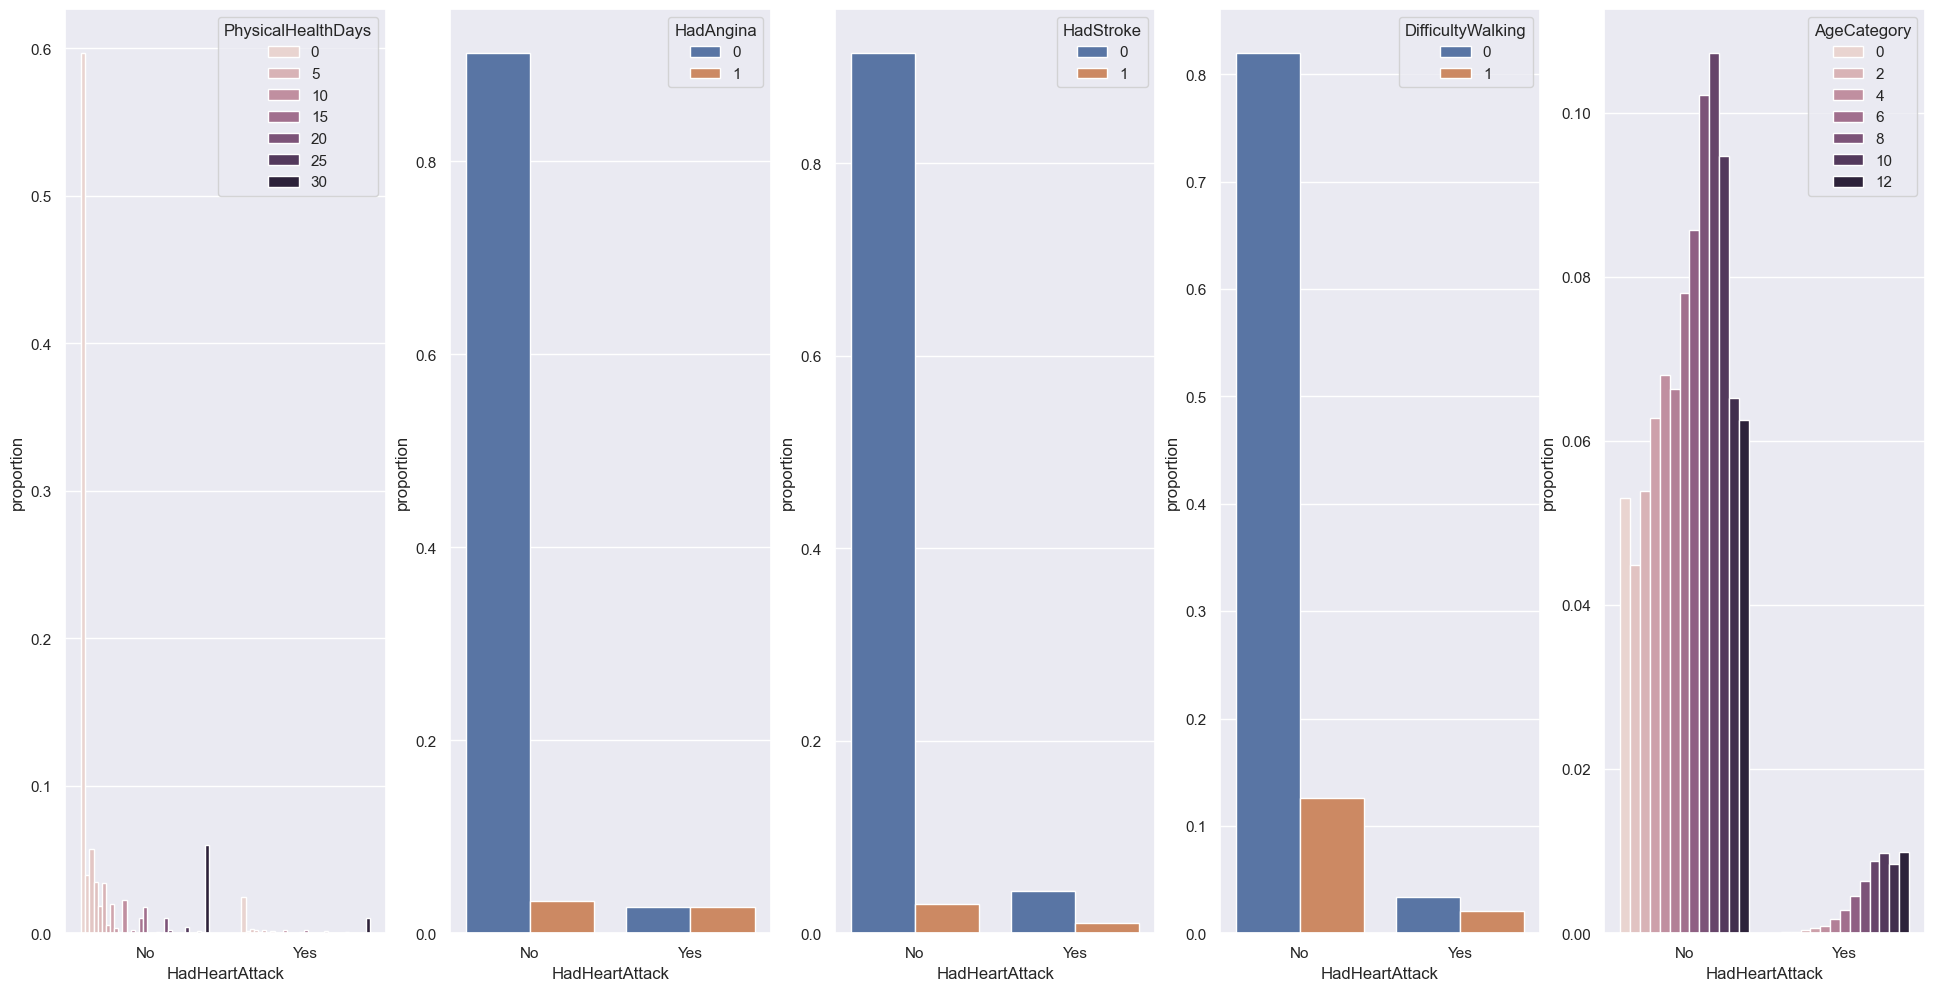

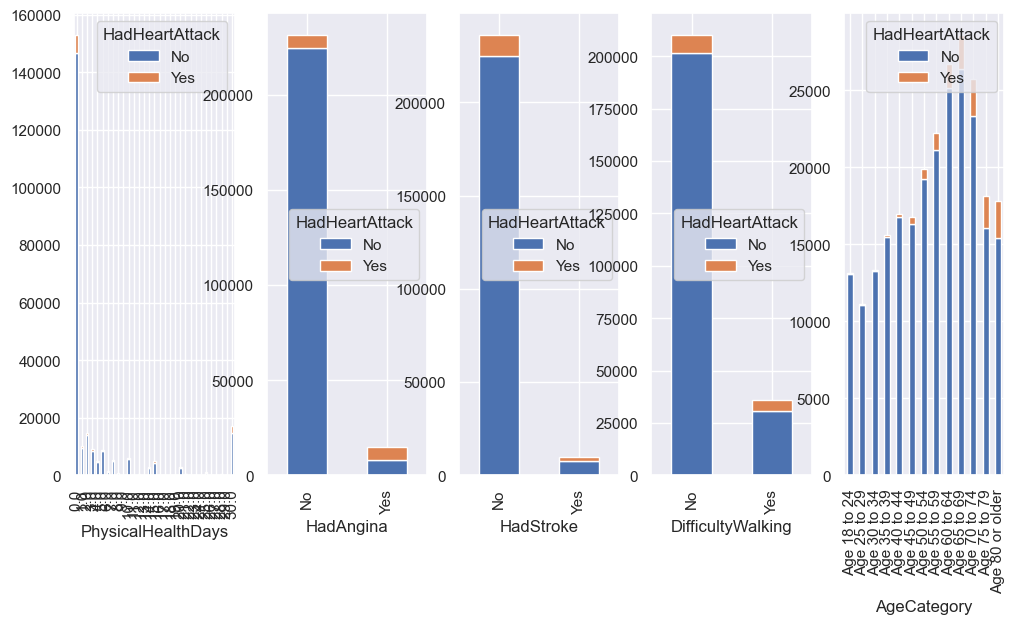

In [19]:
f, axes = plt.subplots(1, n_features, figsize=(24, 12))
for i, col in enumerate(important_features):
    sb.countplot(pd.concat([df_encoded[col], df['HadHeartAttack']], axis=1),
                 x='HadHeartAttack', hue=col, stat='proportion',
                 legend='auto', ax=axes[i])

f, axes = plt.subplots(1, n_features, figsize=(12, 6))
for i, col in enumerate(important_features):
    result= df.groupby(col)['HadHeartAttack'].value_counts().unstack()
    result.plot(kind='bar', stacked=True, ax=axes[i])

(TODO - There has to be a better way to visualize some of these)


From this we can clearly tell that these features are the most important. For instance, The higher one's age category is, the higher the likelihood of someone having a heart attack.

Now we will only use these features for our training from now on.

In [20]:
# Drop the all except these columns
df = df[important_features + ['HadHeartAttack']]

In [21]:
print(df.head())

   PhysicalHealthDays HadAngina HadStroke DifficultyWalking      AgeCategory  \
0                 4.0        No        No                No     Age 65 to 69   
1                 0.0        No        No                No     Age 70 to 74   
2                 0.0        No        No               Yes     Age 75 to 79   
3                 5.0        No        No               Yes  Age 80 or older   
4                 3.0        No        No                No  Age 80 or older   

  HadHeartAttack  
0             No  
1             No  
2             No  
3             No  
4             No  


# Resampling

In [22]:
under = RandomUnderSampler(sampling_strategy=0.5)
over = SMOTE(sampling_strategy=1)
over_under = SMOTEENN()

df_encoded = encode_df(df)

x = df_encoded.drop(['HadHeartAttack'], axis=1)
y = df_encoded['HadHeartAttack']

# x_under, y_under = under.fit_resample(x, y)
# print("Underfit : ", x_under.shape, y_under.shape)

# x_over, y_over = over.fit_resample(x, y)
# print("Overfit : ", x_over.shape, y_over.shape)

x_over, y_over = over_under.fit_resample(x, y)
print("SMOTENN : ", x_over.shape, y_over.shape)


SMOTENN :  (199040, 5) (199040,)


In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.25)

In [24]:
print(x.shape)
print(y.shape)
print(x_train.shape)
print(y_train.shape)

(246022, 5)
(246022,)
(149280, 5)
(149280,)


<h1 align="center"><font color='Blue'>Modeling</font></h1>

Firstly without dropping any columns and performing any sort of analysis to determine importance of features

In [25]:
# We want to use the data that is shuffled outside
# Don't mix shuffling of data into training the model
# All models should share the same set of shuffled data, and if the shuffled
# data should be changed, then we can reuse it again
def train_model(x_train, x_test, y_train, y_test, X, Y, model, cv):
    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    score = cross_val_score(model, X, Y, cv=cv)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    
    print("Train accuracy : ", model.score(x_train, y_train))
    print("Train MSE: ", mean_squared_error(y_train, y_train_pred), '\n')
    
    print("Test accuracy : ", model.score(x_test, y_test))
    print("Test MSE: ", mean_squared_error(y_test, y_test_pred), '\n')

    print("Number of folds: ", cv)
    print("Accuracy score (Cross Validated):", score.mean())
    print("Standard Deviation (Cross Validated): ", ( score.std()), '\n')
    
    # Print the Accuracy Measures from the Confusion Matrix
    cmTrain = confusion_matrix(y_train, y_train_pred)
    tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
    fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)
    
    print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
    print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
    print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
    print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)), '\n')
    
    cmTest = confusion_matrix(y_test, y_test_pred)
    tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
    fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
    tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
    fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)
    
    print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
    print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
    print("FPR Test :\t", (fpTest/(tnTest + fpTest)))
    print("FNR Test :\t", (fnTest/(tpTest + fnTest)), '\n')

    print("Acc : ", accuracy_score(y_test, y_test_pred))
    print("Precision :\t", precision)
    print("Recall :\t", recall)
    print("F1 score :\t", f1)
    

    f,axes = plt.subplots(1,2, figsize=(24,8))
    f.subplots_adjust(hspace=0.5, wspace=0.5)

    # Plot the two-way Confusion Matrix
    sb.heatmap(confusion_matrix(y_train, y_train_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[0])
    axes[0].set_title('Confusion Matrix: Train Data', fontweight='bold', size =20)
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax=axes[1])
    axes[1].set_title('Confusion Matrix: Test Data', fontweight = 'bold', size = 20)
    
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='blue', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Decision Tree Model

**Reasons for using this model:**

- Able to handle both numerical and categorical data
- Able to handle non linear relationships
- Able to show feature imporatance
- Robust to outliers

[Text(0.5, 0.875, 'HadAngina <= 0.5\ngini = 0.222\nsamples = 149280\nvalue = [130333, 18947]'),
 Text(0.25, 0.625, 'PhysicalHealthDays <= 5.083\ngini = 0.096\nsamples = 136351\nvalue = [129480, 6871]'),
 Text(0.125, 0.375, 'HadStroke <= 0.5\ngini = 0.035\nsamples = 108033\nvalue = [106090, 1943]'),
 Text(0.0625, 0.125, 'gini = 0.027\nsamples = 104877\nvalue = [103450, 1427]'),
 Text(0.1875, 0.125, 'gini = 0.274\nsamples = 3156\nvalue = [2640, 516]'),
 Text(0.375, 0.375, 'HadStroke <= 0.5\ngini = 0.287\nsamples = 28318\nvalue = [23390, 4928]'),
 Text(0.3125, 0.125, 'gini = 0.25\nsamples = 26303\nvalue = [22448, 3855]'),
 Text(0.4375, 0.125, 'gini = 0.498\nsamples = 2015\nvalue = [942, 1073]'),
 Text(0.75, 0.625, 'HadStroke <= 0.5\ngini = 0.123\nsamples = 12929\nvalue = [853, 12076]'),
 Text(0.625, 0.375, 'PhysicalHealthDays <= 0.009\ngini = 0.206\nsamples = 6775\nvalue = [792, 5983]'),
 Text(0.5625, 0.125, 'gini = 0.379\nsamples = 279\nvalue = [208, 71]'),
 Text(0.6875, 0.125, 'gini = 0

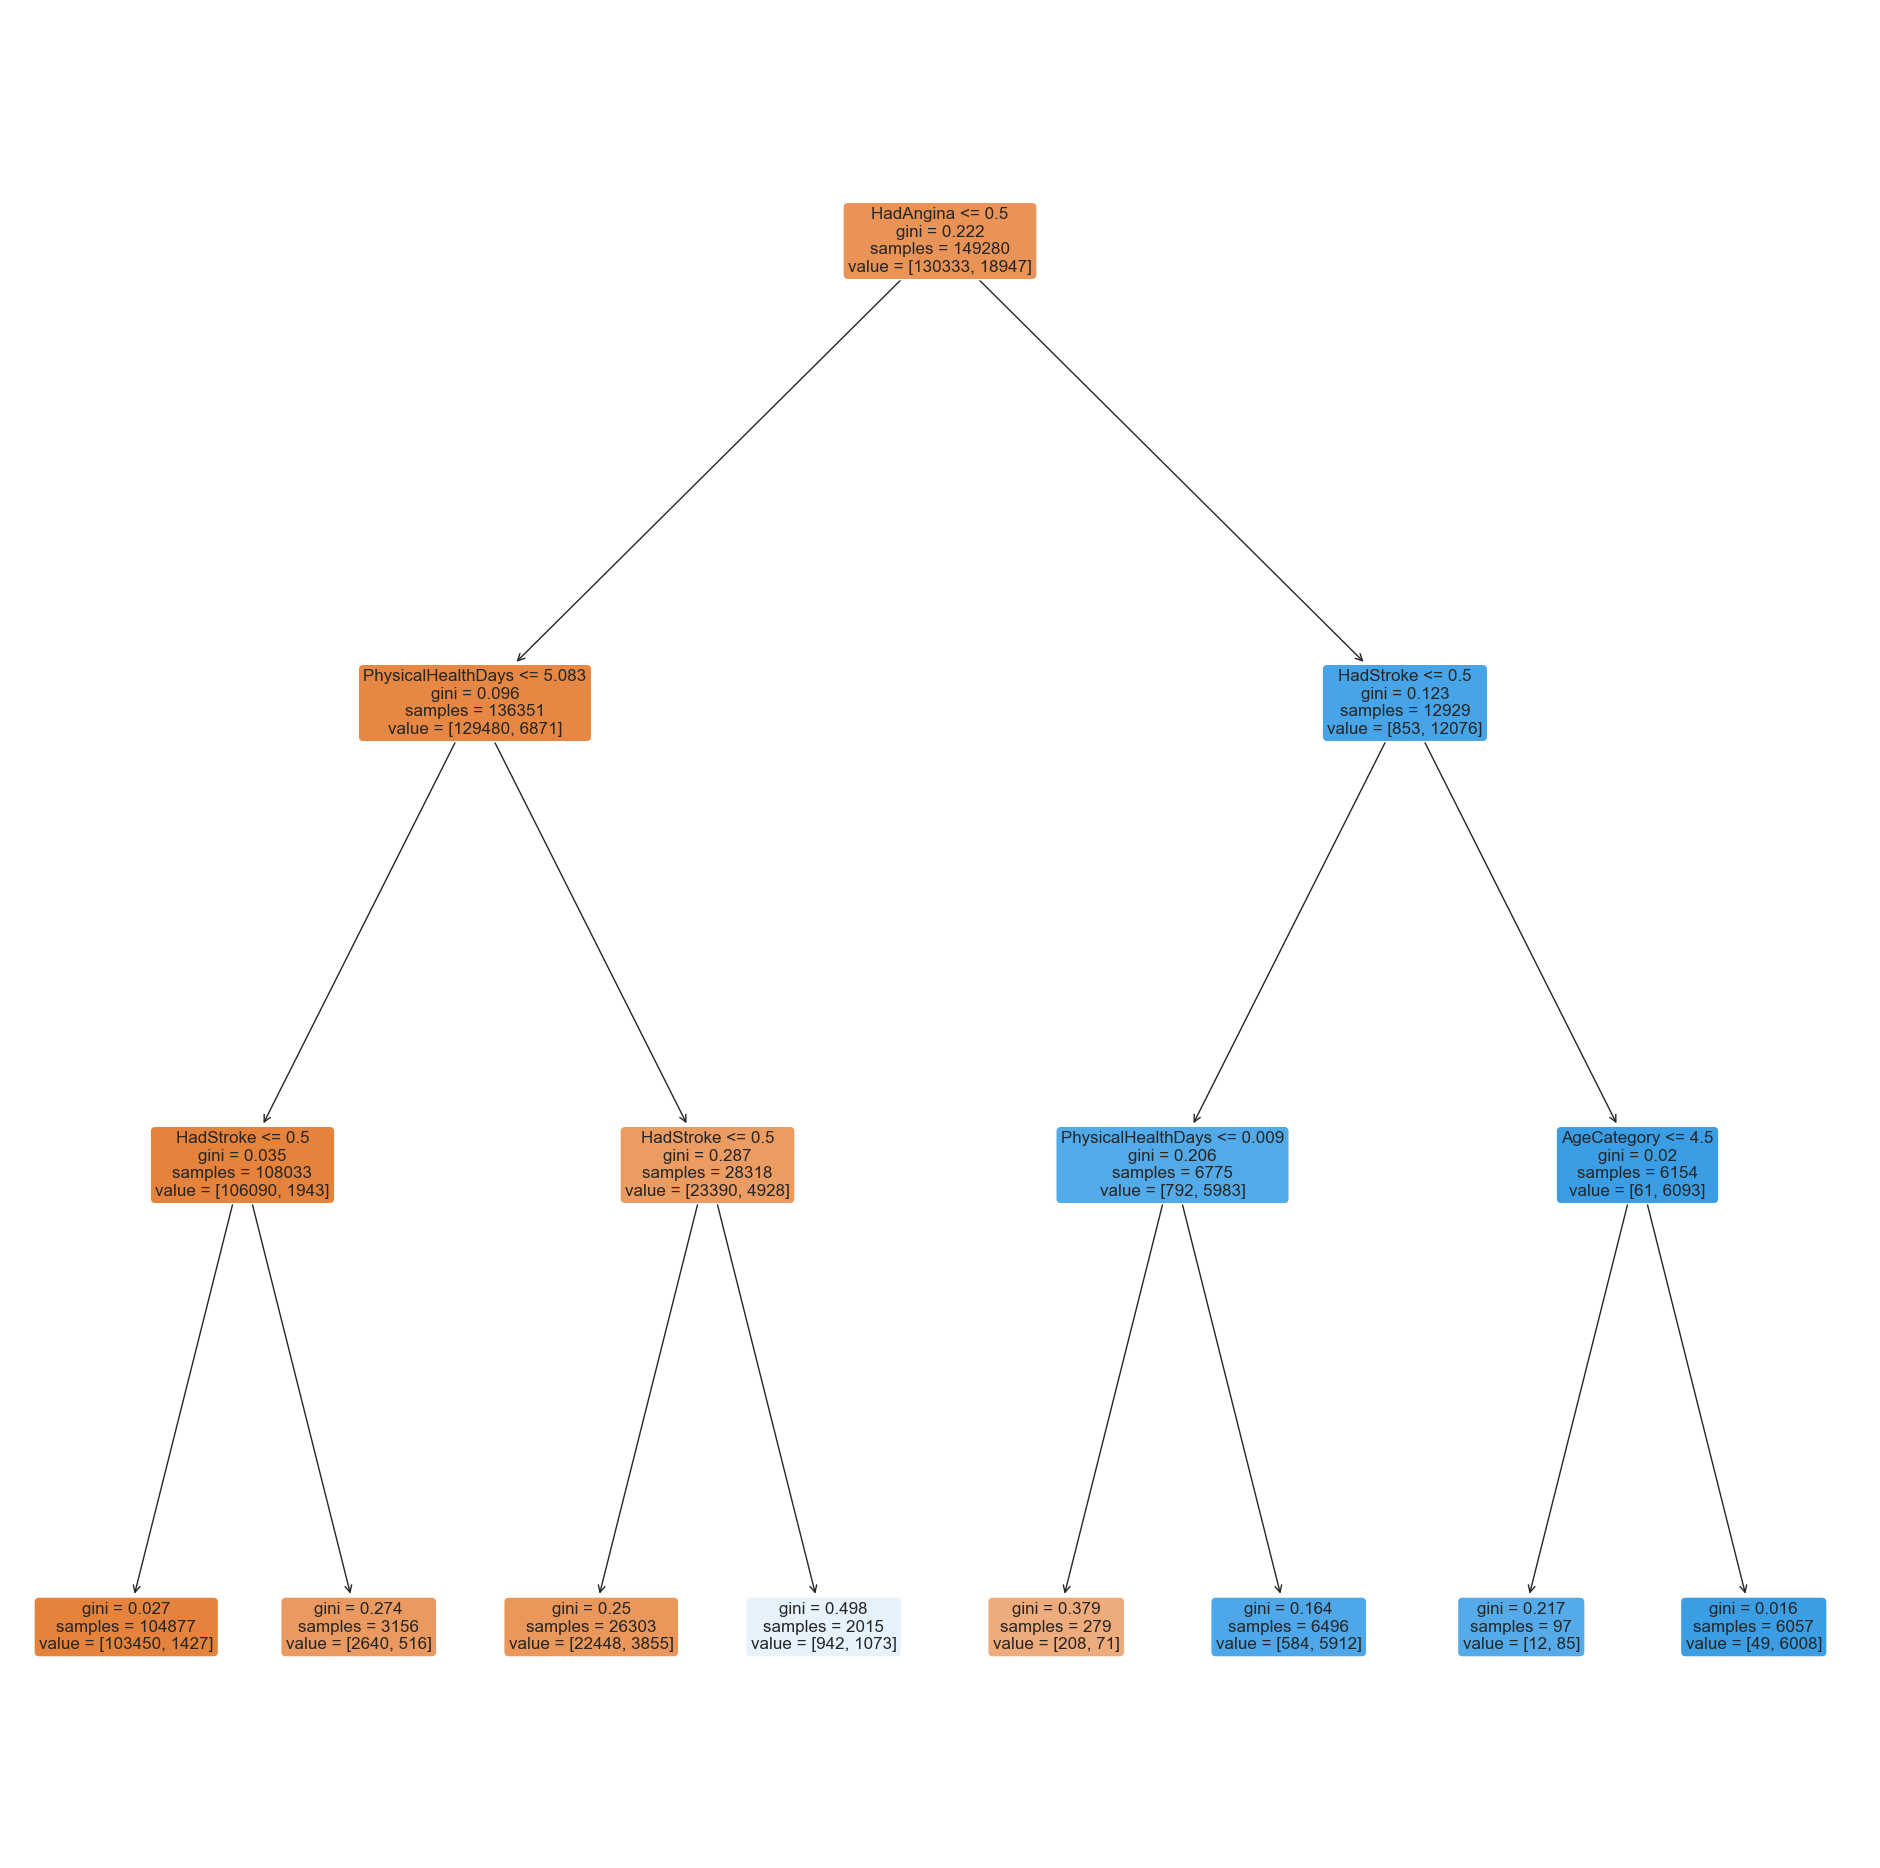

In [26]:
dectree = DecisionTreeClassifier(max_depth = 3)  # change max_depth to experiment
dectree.fit(x_train, y_train)                    # train the decision tree model

# Plot the trained Decision Tree
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, 
          feature_names=x_train.columns.tolist())

Train accuracy :  0.9540728831725617
Train MSE:  0.04592711682743837 

Test accuracy :  0.9531752411575563
Test MSE:  0.04682475884244373 

Number of folds:  5
Accuracy score (Cross Validated): 0.9537630627009646
Standard Deviation (Cross Validated):  0.002186593071030593 

TPR Train :	 0.7119860663957355
TNR Train :	 0.9892659572019366
FPR Train :	 0.010734042798063422
FNR Train :	 0.2880139336042645 

TPR Test :	 0.7094257178526842
TNR Test :	 0.9892046503044842
FPR Test :	 0.010795349695515778
FNR Test :	 0.29057428214731584 

Acc :  0.9531752411575563
Precision :	 0.9066613482249701
Recall :	 0.7094257178526842
F1 score :	 0.7960077044300473


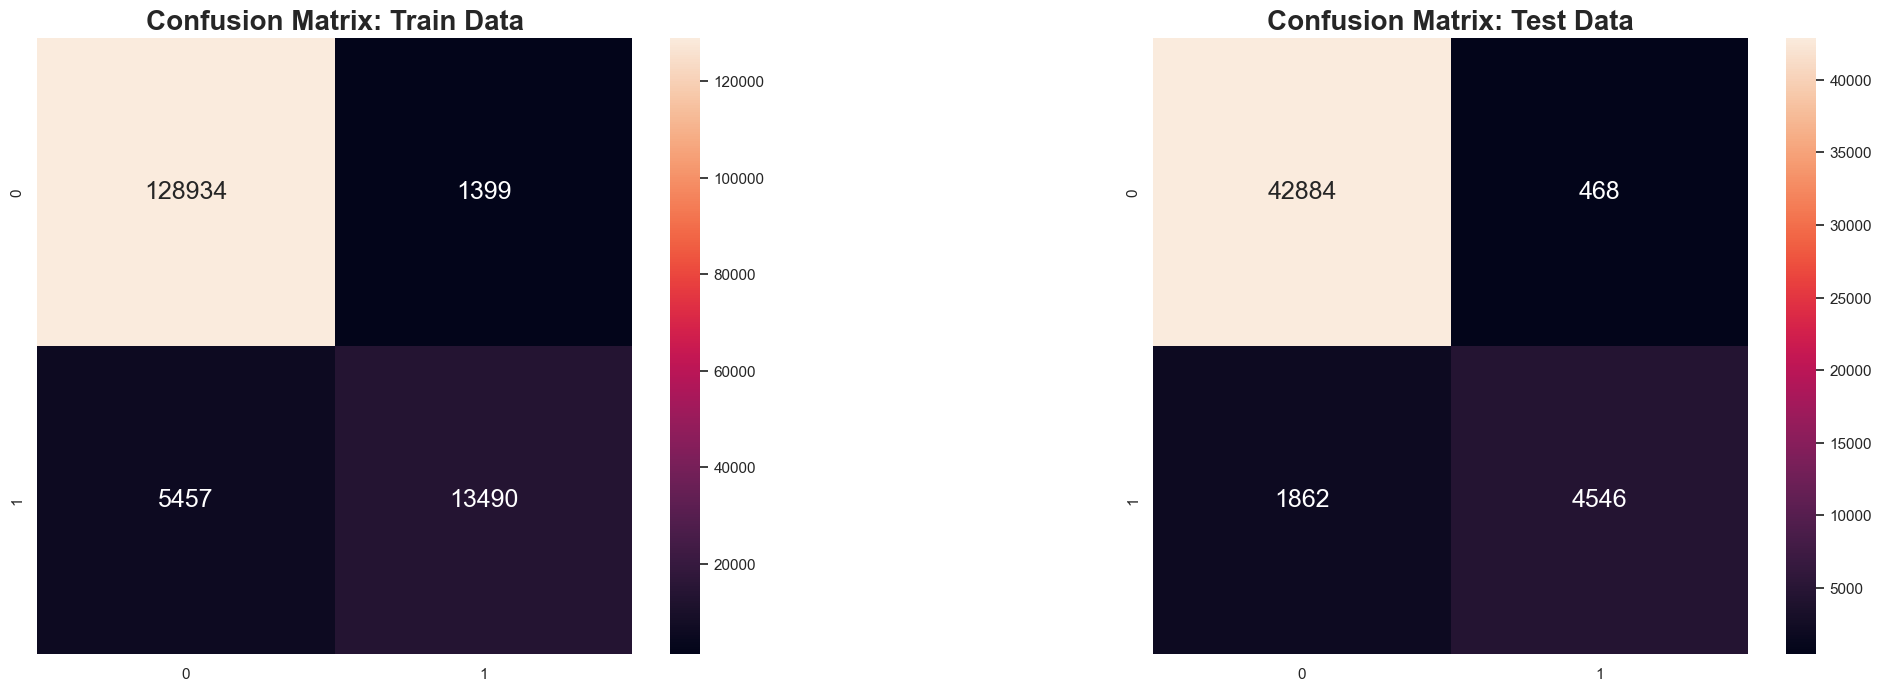

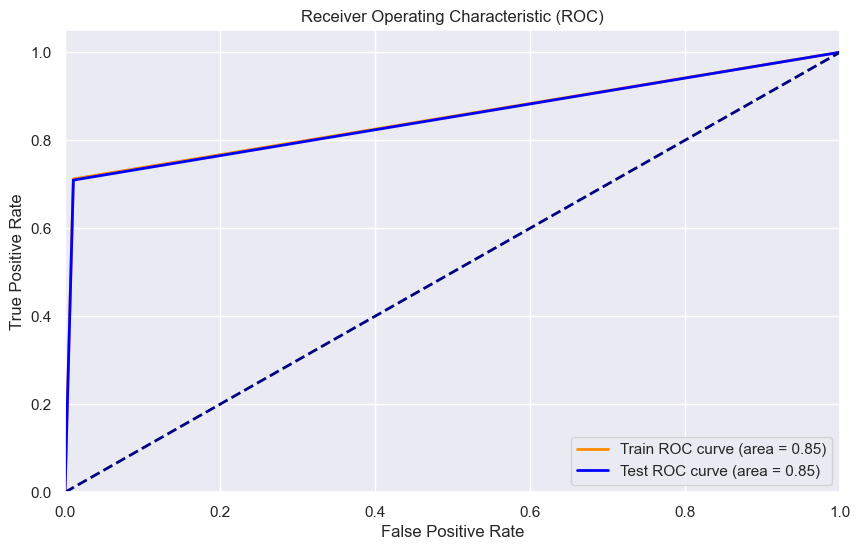

In [28]:
train_model(x_train, x_test, y_train, y_test, x_over, y_over, DecisionTreeClassifier(max_depth = 5), 5)

# Random Forest

**Reasons for use:**

- reduces overfitting by averaging multiple tree decisions
- better accuracy than decision tree (usually)
- automatic feature selection
- 

Train accuracy :  0.976266077170418
Train MSE:  0.023733922829581994 

Test accuracy :  0.9733319935691318
Test MSE:  0.02666800643086817 

Number of folds:  5
Accuracy score (Cross Validated): 0.974366961414791
Standard Deviation (Cross Validated):  0.0014941656061939275 

TPR Train :	 0.8320050667651872
TNR Train :	 0.9972378445980681
FPR Train :	 0.0027621554019319743
FNR Train :	 0.1679949332348129 

TPR Test :	 0.8202247191011236
TNR Test :	 0.995963277357446
FPR Test :	 0.004036722642553977
FNR Test :	 0.1797752808988764 

Acc :  0.9733319935691318
Precision :	 0.9677775731909409
Recall :	 0.8202247191011236
F1 score :	 0.887912830475547


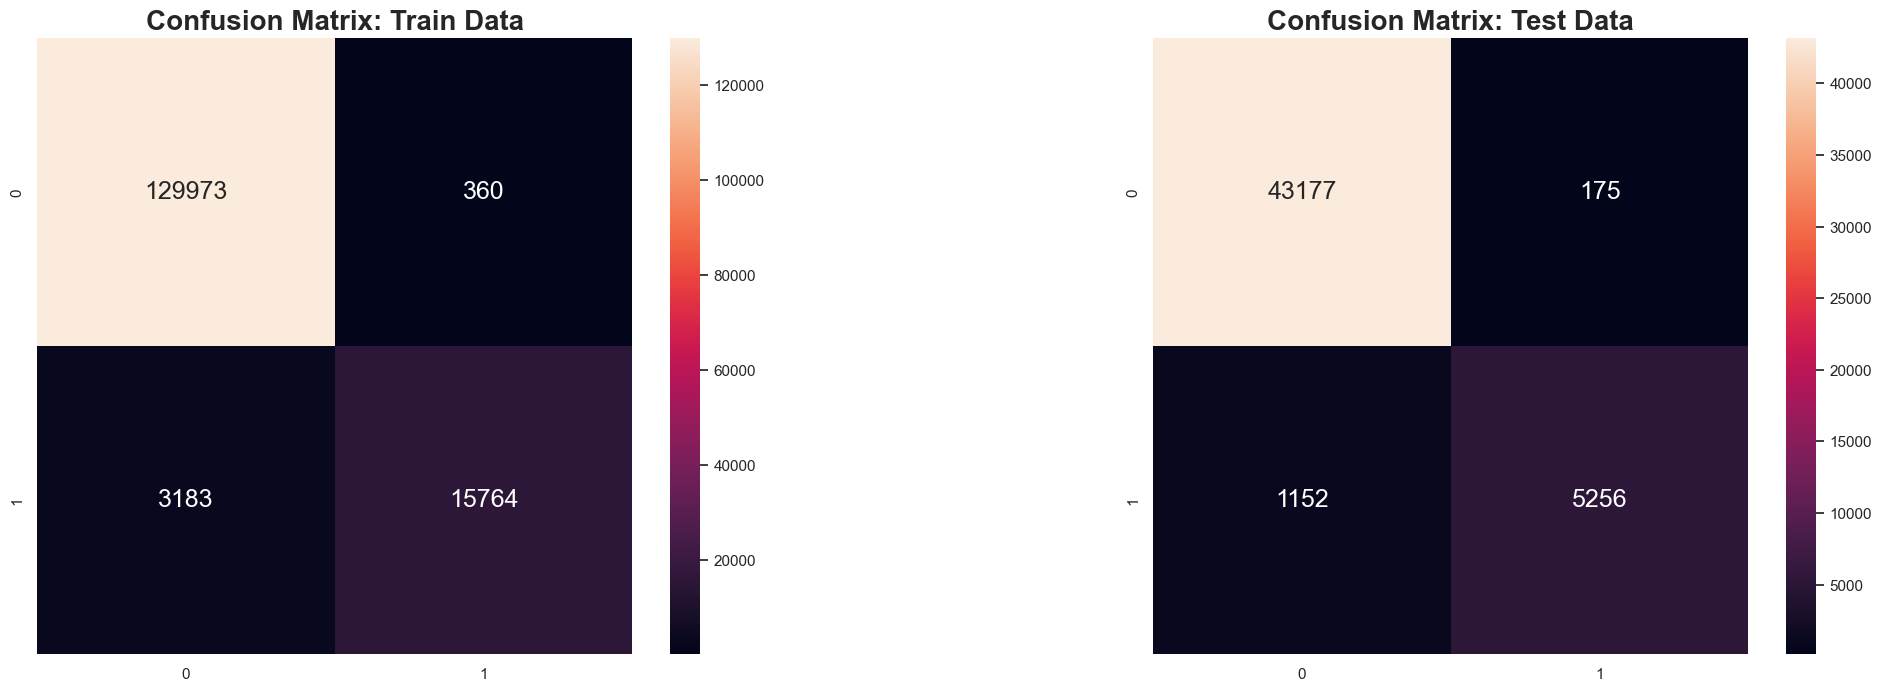

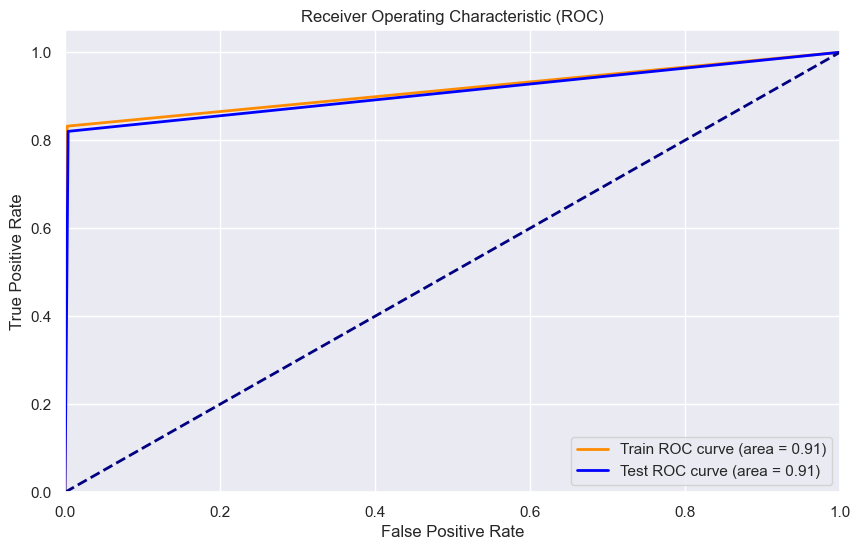

In [29]:
train_model(x_train, x_test, y_train, y_test, x_over, y_over, RandomForestClassifier(), 5)

# Logistic Regression Model

**Reasons for use**

- Robustness to Irrelevant Features
- Works Well with Linearly Separable Data
- Can Handle Both Numeric and Categorical Features

Train accuracy :  0.9459996619514726
Train MSE:  0.05400033804852745 

Test accuracy :  0.9464727001445423
Test MSE:  0.05352729985545764 

Number of folds:  5
Accuracy score (Cross Validated): 0.9460739271199323
Standard Deviation (Cross Validated):  0.0005619574558566739 

TPR Train :	 0.5951853404395473
TNR Train :	 0.9838255614241255
FPR Train :	 0.016174438575874583
FNR Train :	 0.4048146595604527 

TPR Test :	 0.5901204819277108
TNR Test :	 0.9846427833987198
FPR Test :	 0.015357216601280197
FNR Test :	 0.4098795180722892 

Acc :  0.9464727001445423
Precision :	 0.8045335085413929
Recall :	 0.5901204819277108
F1 score :	 0.6808451487350571


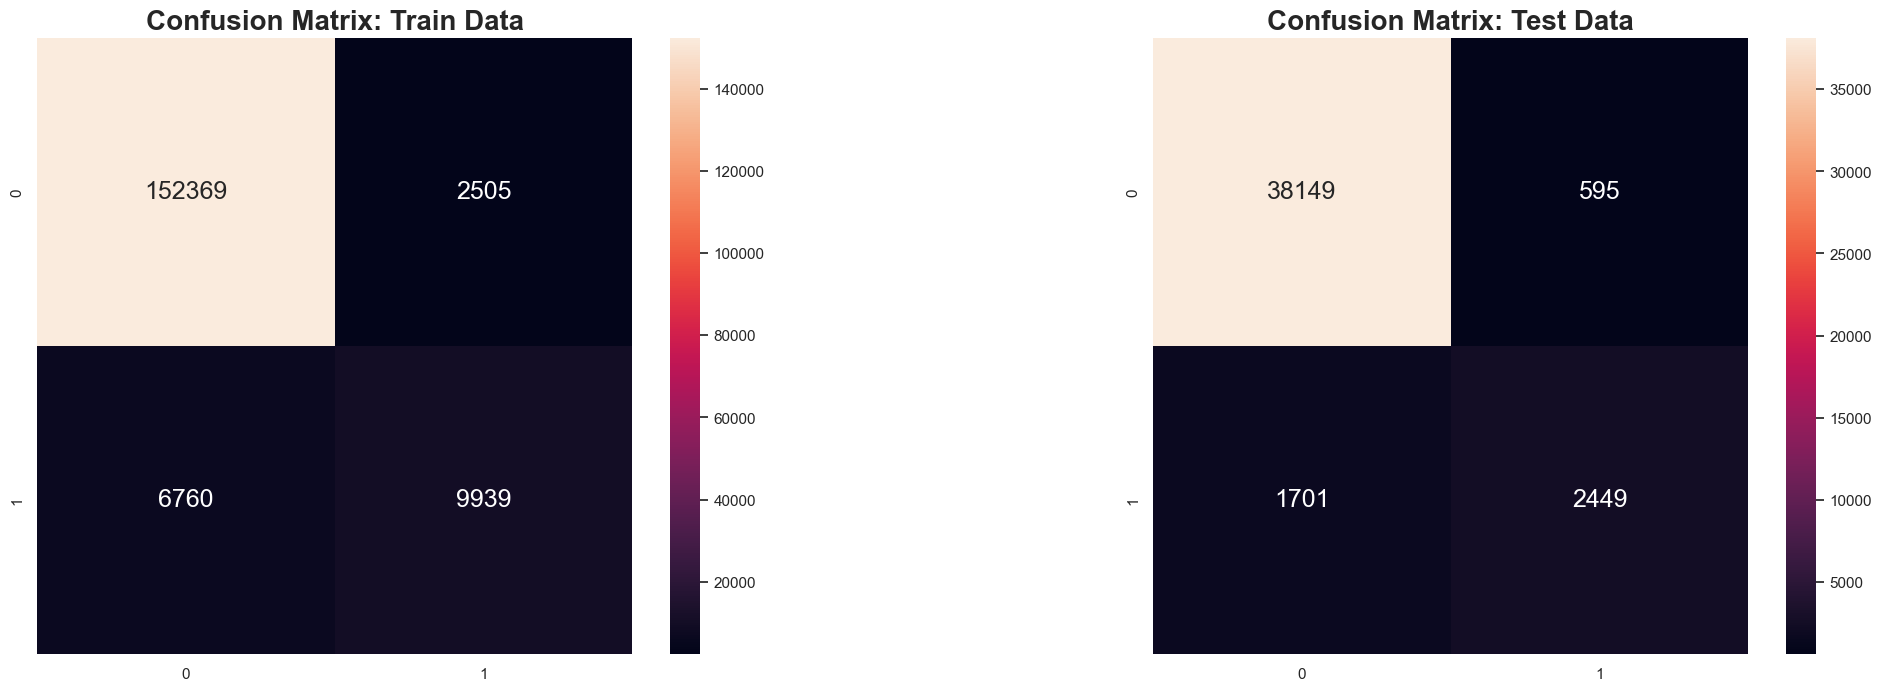

In [32]:
train_model(x_train, x_test, y_train, y_test, x_over, y_over LogisticRegression(), 5)

# SVC Model

- (To Do)

In [ ]:
train_model(x_train, x_test, y_train, y_test, SVC(gamma='auto'), 5)

# Fine tuning the model for better results

# Discussion about results

While our random forest has the highest accuracy, the better measure of our model would be the **RECALL** and **F1** metric as the aim of our model is to predict the likelihood someone will develop a **Heart Attack** based on their medical history. As recall is the measure of how many **True positives** against the whole **Positive** class (HadHeartAttack) a higher recall will be preferred as it means that our model can have a high accuracy of predicting when someone will have a heart attack. In short, we want to reduce the number of false negatives as it would miss a person possibly having a heart attack

Of course this does not mean we only look at **Recall** but **Recall** compared to the overall accuracy of the model as the model would not be very good if it classifies everyone as about to have heart attack